<a href="https://www.kaggle.com/code/lr1224/fellowship-ai-nlp-assignment?scriptVersionId=128724304" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

RANDOM_SEED = 424242

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Examine Data

In [2]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


* 50k rows, 2 cols
* 2 classes (labels, positive and negative)

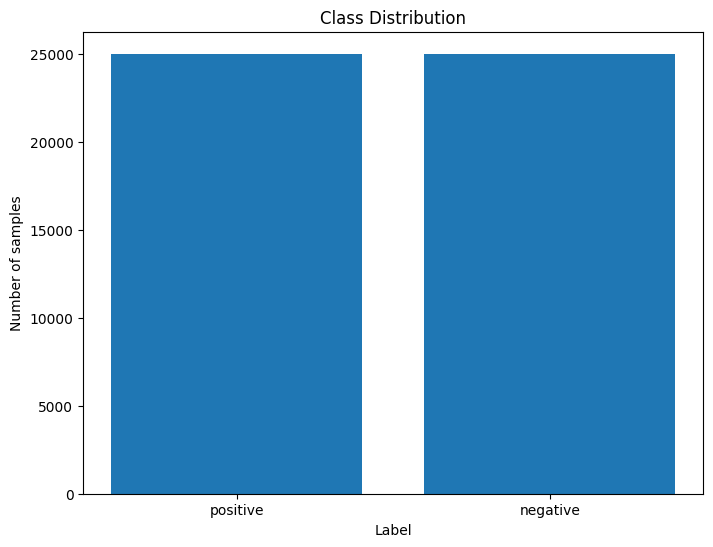

In [3]:
label_counts = data['sentiment'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.xticks(label_counts.index)
plt.show()


* Classes are pretty evenly distributed, which means no need for under/over sampling.

# Tokenization/Encoding

In [4]:
# Spacy does quite a bit of cleanup underneath that the 'normal' English tokenizer does not
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Regex to remove HTML tags
clean_html_regex = re.compile('<.*?>')
# Regex to remove anything that is not a word character or a space
clean_punctuation_regex = re.compile('[^\w\s]')

# This generator will yield token for text contained in iterator, apply our regexes to clean up the text
def yield_tokens(data_iter):
    for _, text in data_iter:
        text = clean_html_regex.sub('', text)
        text = clean_punctuation_regex.sub('', text)
        yield tokenizer(text)

In [5]:
# Build vocab, remember in PD, itertuples tends to be faster than iterrows
vocab = build_vocab_from_iterator(yield_tokens(data['review'].items()), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [6]:
# Write wrapper function that will tokenize and then encode our text
def encode_text(text):
    return [vocab[token] for token in tokenizer(text)]

def encode_sentiment(sentiment):
    if sentiment == 'positive':
        return 0
    if sentiment == 'negative':
        return 1

# Create Data Module 
### (Manages data during training/validation)

In [7]:
class IMDBReviewDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data.iloc[idx]
        encoded_text = encode_text(text)
        encoded_label = encode_sentiment(label)

        return torch.tensor(encoded_text, dtype=torch.long), torch.tensor(encoded_label, dtype=torch.float32)

    def collate_fn(self, batch):
        sequences = [seq[0] for seq in batch]
        labels = [seq[1] for seq in batch]

        # Pad sequences
        sequences = pad_sequence(sequences, batch_first=True, padding_value=self.vocab['<pad>'])
        labels_tensor = torch.stack(labels)

        return sequences, labels_tensor

In [8]:
class IMDBReviewDataModule(pl.LightningDataModule):
    def __init__(self, data, vocab, batch_size=32, val_split=0.2):
        super().__init__()
        self.val_dataset = None
        self.train_dataset = None
        self.data = data
        self.vocab = vocab
        self.batch_size = batch_size
        self.val_split = val_split

    def setup(self, stage=None):
        dataset = IMDBReviewDataset(self.data, self.vocab)
        n_val = int(len(dataset) * self.val_split)
        n_train = len(dataset) - n_val
        self.train_dataset, self.val_dataset = random_split(dataset, [n_train, n_val])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          collate_fn=self.train_dataset.dataset.collate_fn, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.val_dataset.dataset.collate_fn,
                          num_workers=4)

# Create Model Definition
### (Defines the layers of our model and forward prop)

In [9]:
# Our model

class IMDBReviewModelDefinition(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_hidden_units, num_classes=2):
        super().__init__()
        # Converts encoded words into embedding vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Gated recurrent unit (RNN with update + reset gates)
        self.gru = nn.GRU(embedding_dim, rnn_hidden_units, batch_first=True)
        # Convolutional layer, kernel_size = 3 to capture trigrams ("not very good"/"really enjoyed it")
        self.conv = nn.Conv1d(rnn_hidden_units, rnn_hidden_units, kernel_size=3, padding=1)
        # Adaptive average pooling layer
        self.adaptive_avgpool = nn.AdaptiveAvgPool1d(1)
        # Dense/Output layer
        self.fc = nn.Linear(in_features=rnn_hidden_units, out_features=1)

    def forward(self, x):
        # Create embedding from input
        x = self.embedding(x)
        # GRU
        x, _ = self.gru(x)
        # Change input dim to match Conv layer
        x = x.permute(0, 2, 1)
        # Convolution
        x = self.conv(x)
        # Activation
        x = F.relu(x)
        # Adaptive average pooling
        x = self.adaptive_avgpool(x)
        # Change input dim to match FC layer
        x = x.view(x.size(0), -1)
        # Output layer
        x = self.fc(x)
        # Sigmoid activation
        x = torch.sigmoid(x)

        return x.squeeze()

# Create Lightning Module
### (Holds our training logic)

In [10]:
class IMDBReviewModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, rnn_hidden_units, learning_rate=1e-3):
        super().__init__()
        # Model def used
        self.model_definition = IMDBReviewModelDefinition(vocab_size, embedding_dim, rnn_hidden_units)
        # Our "loss" function. BCE because we're doing
        # binary classification (positive/negative)
        self.criterion = nn.BCELoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model_definition(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        logits = self(inputs)
        loss = self.criterion(logits, labels)
        self.log('training_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        logits = self(inputs)
        loss = self.criterion(logits, labels)
        self.log('validation_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model_definition.parameters(), lr=self.learning_rate)
        return optimizer

# Train for 10 epochs

In [11]:
# Model parameters
vocab_size = len(vocab)
embedding_dim = 100
rnn_hidden_units = 128

# Uncomment/comment this depending on whether you'd like to load an existing checkpoint below
data_module = IMDBReviewDataModule(vocab=vocab, data=data, batch_size=32)

model = IMDBReviewModel(len(vocab), embedding_dim, rnn_hidden_units)
# Comment the line below if you don't have tensor cores
# torch.set_float32_matmul_precision('medium')

trainer = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer.fit(model, datamodule=data_module)

# Uncomment below if you'd like to save a checkpoint
# torch.save(model, 'model.pth')

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# New data

In [12]:
test_reviews = {
    "I absolutely loved this movie. The acting was top-notch and the story was gripping.": 0,
    "What a waste of time. The plot was slow and the acting was terrible.": 1,
    "This movie was so boring. I fell asleep halfway through.": 1,
    "This is one of my all-time favorite movies. The characters were so well-developed and the story was powerful.": 0,
    "I couldn't stand this movie. The acting was cheesy and the plot was predictable.": 1,
    "The cinematography was amazing, but the story fell flat for me.": 1,
    "This movie was incredible! I was on the edge of my seat throughout the entire thing.": 0,
    "The acting in this movie was terrible. I don't know how it got such good reviews.": 1,
    "I didn't think I was going to like this movie, but I ended up loving it.": 0,
    "This movie was so depressing. I don't know if I'll ever be able to watch it again.": 1,
    "The special effects in this movie were incredible, but the story left something to be desired.": 1,
    "I thought this movie was going to be terrible, but it ended up being really good.": 0,
    "I didn't understand the hype around this movie. It was just okay.": 1,
    "This movie was so intense. I was on the edge of my seat the whole time.": 0,
    "The acting in this movie was phenomenal. It was a joy to watch.": 0,
    "I couldn't believe how bad this movie was. I regret wasting my time watching it.": 1,
    "The story in this movie was so heartwarming. I cried multiple times.": 0,
    "This movie was a masterpiece. I can't wait to watch it again.": 0,
    "I was really disappointed with this movie. It didn't live up to the hype.": 1,
    "This movie was a rollercoaster of emotions. I laughed and cried and everything in between.": 0,
    "I don't know why everyone loves this movie so much. I thought it was just okay.": 1,
    "This movie was so bad that I couldn't even finish it.": 1,
    "The soundtrack for this movie was amazing. I downloaded it as soon as the movie was over.": 0,
    "This movie was so romantic. I loved every minute of it.": 0,
    "I was so invested in this movie. I couldn't look away.": 0,
    "This movie was really confusing. I'm still not sure what happened.": 1,
    "I thought this movie was going to be great, but it ended up being really disappointing.": 1,
    "This movie was so scary that I had to watch it with the lights on.": 0,
    "The acting in this movie was terrible. I can't believe they got such big-name actors to star in it.": 1,
    "I thought this movie was really well done. The pacing was perfect and the acting was great.": 0,
    "I can't believe I wasted my time watching this movie. It was terrible.": 1,
    "The plot of this movie was so convoluted that I couldn't follow it.": 1,
    "This movie was hilarious. I was laughing out loud the whole time.": 0,
    "I thought the ending of this movie was really unsatisfying.": 1,
    "This movie was so beautiful. I was moved to tears.": 0,
    "I don't know why this movie got such good reviews. It was awful.": 1,
    "This movie was a real tear-jerker. I was crying from start to finish.": 0,
    "I thought the special effects in this movie were really impressive.": 0,
    "This movie was really thought-provoking. I've been thinking about it ever since I watched it.": 0,
    "I didn't think I was going to like this movie, but it ended up being really good.": 0,
    "The plot twists in this movie were so unexpected. I was completely shocked.": 0,
    "The dialogue in this movie was so cheesy. I couldn't take it seriously.": 1,
    "The character development in this movie was amazing. I felt so connected to the characters.": 0,
    "This movie was way too long. I couldn't wait for it to be over.": 1,
    "The action scenes in this movie were incredible. I was on the edge of my seat.": 0,
    "The pacing in this movie was so slow. I lost interest halfway through.": 1,
    "I loved the music in this movie. It really set the mood.": 0,
    "The storyline in this movie was so confusing. I couldn't follow it at all.": 1,
    "The scenery in this movie was breathtaking. It was like watching a work of art.": 0,
    "This movie was so overrated. I don't understand why everyone loves it so much.": 1,
    "The chemistry between the actors in this movie was amazing. I felt so invested in their relationship.": 0,
    "This movie was so predictable. I saw the ending coming from a mile away.": 1,
    "I loved the costumes in this movie. They really helped to create a believable world.": 0,
    "The acting in this movie was so wooden. It felt like they were just reading their lines.": 1,
    "The storyline in this movie was so original. I've never seen anything like it.": 0,
    "This movie was a complete mess. It felt like they were trying to cram too much into one film.": 1,
    "The visuals in this movie were stunning. I felt like I was in another world.": 0,
    "This movie was so over-the-top. It felt like a parody of itself.": 1,
    "I loved the themes in this movie. It really made me think about life.": 0,
    "This movie was so slow-paced. I struggled to stay awake.": 1,
    "The relationships in this movie were so well-developed. I was completely invested in them.": 0,
    "The humor in this movie fell flat. I didn't laugh once.": 1,
    "I loved the cinematography in this movie. It was truly breathtaking.": 0,
    "This movie was so unrealistic. I couldn't suspend my disbelief.": 1,
    "The performances in this movie were outstanding. Each actor brought their character to life.": 0,
    "The plot in this movie was so thin. It felt like nothing happened.": 1,
    "This movie was so poorly written. The dialogue was cringe-worthy.": 1,
    "The emotions in this movie were so raw and powerful. I was moved to tears.": 0,
    "This movie was so disjointed. It felt like it was all over the place.": 1,
    "I loved the attention to detail in this movie. The sets and costumes were amazing.": 0,
    "This movie was such a disappointment. I had high hopes, but it just didn't deliver.": 1,
    "The character arcs in this movie were so well done. I was completely invested in their journeys.": 0,
    "This movie was so clichéd. I felt like I'd seen it a hundred times before.": 1,
    "The world-building in this movie was incredible. I was completely immersed in the story.": 0,
    "This movie was so poorly directed. The scenes just didn't flow well together.": 1,
    "The acting in this movie was superb. Each actor truly embodied their character.": 0,
    "The storyline in this movie was so weak. It just didn't hold my interest.": 1,
    "I loved the creativity in this movie. It was such a unique and original concept.": 0,
    "This movie was so dull. I just couldn't get into it.": 1,
    "The suspense in this movie was masterfully done. I was on the edge of my seat.": 0,
    "This movie was so poorly edited. The pacing was all over the place.": 1,
    "The animation in this movie was stunning. It was visually breathtaking.": 0,
    "This movie was so melodramatic. I couldn't take it seriously.": 1,
    "I loved the complexity of the plot in this movie. It kept me guessing until the end.": 0,
    "This movie was so formulaic. I knew exactly what was going to happen.": 1,
    "The acting in this movie was top-notch. The performances were truly memorable.": 0,
    "This movie was such a letdown. The plot was full of holes.": 1,
    "I loved the way this movie explored deep and meaningful themes. It really made me think.": 0,
    "This movie was so over-hyped. It didn't live up to my expectations.": 1,
    "The visual effects in this movie were outstanding. I was completely blown away.": 0,
    "This movie was so poorly executed. It had potential, but it just fell flat.": 1,
    "I loved the witty dialogue in this movie. It was so entertaining.": 0,
    "This movie was such a snoozefest. I couldn't wait for it to be over.": 1,
    "The ensemble cast in this movie was fantastic. Their performances were all top-notch.": 0,
    "This movie was such a trainwreck. I couldn't believe how bad it was.": 1,
    "I loved the atmosphere in this movie. It was so immersive and captivating.": 0,
    "This movie was so forgettable. I barely remember what happened.": 1,
    "The storytelling in this movie was masterful. I was hooked from start to finish.": 0,
    "This movie was such a mess. The plot was confusing and hard to follow.": 1,
    "I loved the chemistry between the lead actors in this movie. It felt so genuine.": 0,
    "This movie was way too predictable. I saw every twist coming a mile away.": 1,
    "The score in this movie was absolutely beautiful. It added so much depth and emotion.": 0,
    "This movie was so overrated. I don't understand why people liked it so much.": 1,
    "The cinematography in this movie was stunning. It was a visual masterpiece.": 0,
    "This movie was so boring. I struggled to stay awake during it.": 1,
    "I loved the character development in this movie. It was so well done.": 0,
    "This movie was just terrible. The acting was so wooden and the plot was nonsensical.": 1,
    "The pacing in this movie was perfect. It kept me engaged and interested throughout.": 0,
    "This movie was so frustrating. It had a great premise, but the execution was awful.": 1,
    "I loved the twists and turns in this movie. It kept me guessing until the very end.": 0,
    "This movie was a disaster. The special effects were laughably bad.": 1,
    "The performances in this movie were so powerful. I was completely drawn in.": 0,
    "This movie was so over-the-top. It felt like it was trying too hard to be edgy.": 1,
    "I loved the humor in this movie. It had me laughing out loud multiple times.": 0,
    "This movie was such a letdown. The characters were so one-dimensional.": 1,
    "The action sequences in this movie were exhilarating. I was on the edge of my seat.": 0,
    "This movie was a complete waste of time. The plot was incoherent and confusing.": 1,
    "I loved the emotional depth of this movie. It really resonated with me.": 0,
    "This movie was so poorly written. The dialogue was cringeworthy and the plot was weak.": 1,
    "The visuals in this movie were absolutely breathtaking. I was mesmerized by the scenery.": 0,
    "This movie was so disappointing. I expected so much more from the cast and director.": 1,
    "I loved the subtle storytelling in this movie. It was a refreshing change of pace.": 0,
    "This movie was so tedious. I couldn't wait for it to end.": 1,
}

# Predict on new data

In [13]:
# Set the model to evaluation mode
model.eval()

correct_predictions = 0
total_predictions = 0

for review, test_label in test_reviews.items():
    review_tensor = torch.tensor(encode_text(review), dtype=torch.long).unsqueeze(0)
    # Our model was trained on padded sequences, so we must pad this input as well
    sequence = pad_sequence(review_tensor, batch_first=True, padding_value=vocab['<pad>'])

    sentiment = model(sequence)
    predicted_label = int(sentiment.item() > 0.5)  # Convert the output to a binary label

    if predicted_label == test_label:
        correct_predictions += 1

    # Print the predicted and actual sentiment labels for the current review
    print(f""
          f"Review: {review}\n"
          f"Sentiment Value: {sentiment.item():.4f}\n"
          f"Predicted label: {'positive' if predicted_label == 0 else 'negative'}\n"
          f"Actual label: {'positive' if test_label == 0 else 'negative'}\n"
          )

    total_predictions += 1

Review: I absolutely loved this movie. The acting was top-notch and the story was gripping.
Sentiment Value: 0.0000
Predicted label: positive
Actual label: positive

Review: What a waste of time. The plot was slow and the acting was terrible.
Sentiment Value: 1.0000
Predicted label: negative
Actual label: negative

Review: This movie was so boring. I fell asleep halfway through.
Sentiment Value: 1.0000
Predicted label: negative
Actual label: negative

Review: This is one of my all-time favorite movies. The characters were so well-developed and the story was powerful.
Sentiment Value: 0.0000
Predicted label: positive
Actual label: positive

Review: I couldn't stand this movie. The acting was cheesy and the plot was predictable.
Sentiment Value: 1.0000
Predicted label: negative
Actual label: negative

Review: The cinematography was amazing, but the story fell flat for me.
Sentiment Value: 1.0000
Predicted label: negative
Actual label: negative

Review: This movie was incredible! I was on

# Calculate the accuracy on the test set

In [14]:
accuracy = correct_predictions / total_predictions * 100

print(f"Results:")
print(f"Incorrect predictions: {total_predictions - correct_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Total predictions: {total_predictions}")
print(f"Accuracy: {accuracy:.2f}%")

Results:
Incorrect predictions: 10
Correct predictions: 113
Total predictions: 123
Accuracy: 91.87%
